In [1]:
import logging
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from icecream import ic

import random

Cost: $d + (d \cdot \alpha \cdot w)^\beta$ with $\alpha \ge 0$ and $\beta \ge 0$

In [2]:
class Problem:
    _graph: nx.Graph
    _alpha: float
    _beta: float

    def __init__(
        self,
        num_cities: int,
        *,
        alpha: float = 1.0,
        beta: float = 1.0,
        density: float = 0.5,
        seed: int = 42,
    ):
        rng = np.random.default_rng(seed)
        self._alpha = alpha
        self._beta = beta
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5

        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))

        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

        assert nx.is_connected(self._graph)

    @property
    def graph(self) -> nx.Graph:
        return nx.Graph(self._graph)

    @property
    def alpha(self):
        return self._alpha

    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        total_cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='dist'
        ).items():
            cost = 0
            for c1, c2 in zip(path, path[1:]):
                cost += self.cost([c1, c2], 0)
                cost += self.cost([c1, c2], self._graph.nodes[dest]['gold'])
            logging.debug(
                f"dummy_solution: go to {dest} ({' > '.join(str(n) for n in path)} ({cost})"
            )
            total_cost += cost
        return total_cost

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.get_node_attributes(self._graph, 'pos')
        size = [100] + [self._graph.nodes[n]['gold'] for n in range(1, len(self._graph))]
        color = ['red'] + ['lightblue'] * (len(self._graph) - 1)
        return nx.draw(self._graph, pos, with_labels=True, node_color=color, node_size=size)

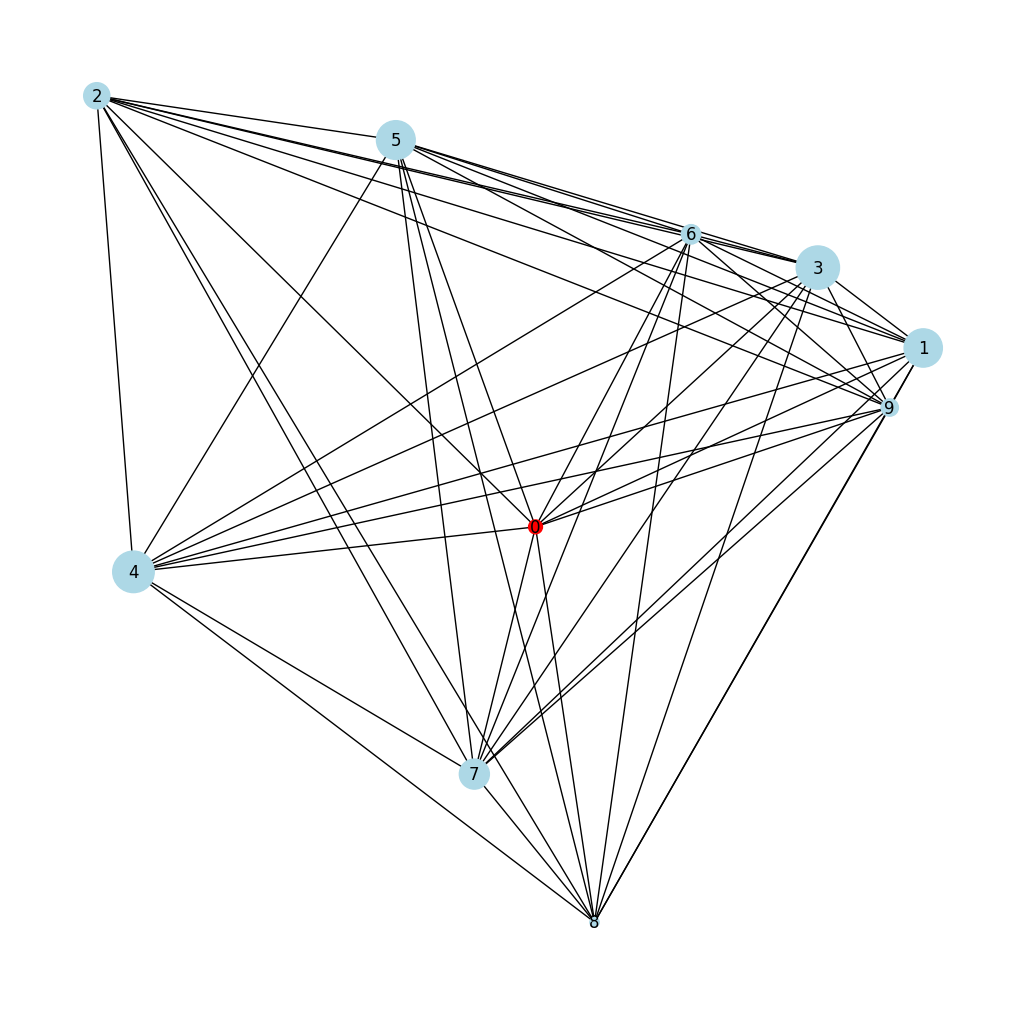

In [3]:
P = Problem(10, density=1, alpha=2, beta=1)
P.plot()

In [4]:
P.graph.nodes[9]

{'pos': (np.float64(0.8276311719925821), np.float64(0.6316643991220648)),
 'gold': 155.1352025754803}

In [5]:
logging.getLogger().setLevel(logging.WARNING)

ic(Problem(100, density=0.2, alpha=1, beta=1).baseline())
ic(Problem(100, density=0.2, alpha=2, beta=1).baseline())
ic(Problem(100, density=0.2, alpha=1, beta=2).baseline())
ic(Problem(100, density=1, alpha=1, beta=1).baseline())
ic(Problem(100, density=1, alpha=2, beta=1).baseline())
ic(Problem(100, density=1, alpha=1, beta=2).baseline())
ic(Problem(1_000, density=0.2, alpha=1, beta=1).baseline())
ic(Problem(1_000, density=0.2, alpha=2, beta=1).baseline())
ic(Problem(1_000, density=0.2, alpha=1, beta=2).baseline())
ic(Problem(1_000, density=1, alpha=1, beta=1).baseline())
ic(Problem(1_000, density=1, alpha=2, beta=1).baseline())
ic(Problem(1_000, density=1, alpha=1, beta=2).baseline())
None

ic| Problem(100, density=0.2, alpha=1, beta=1).baseline(): np.float64(25266.40561851072)
ic| Problem(100, density=0.2, alpha=2, beta=1).baseline(): np.float64(50425.30961817918)
ic| Problem(100, density=0.2, alpha=1, beta=2).baseline(): np.float64(5334401.927002504)
ic| Problem(100, density=1, alpha=1, beta=1).baseline(): np.float64(18266.18579582672)
ic| Problem(100, density=1, alpha=2, beta=1).baseline(): np.float64(36457.918462372065)
ic| Problem(100, density=1, alpha=1, beta=2).baseline(): np.float64(5404978.08899582)
ic| Problem(1_000, density=0.2, alpha=1, beta=1).baseline(): np.float64(195402.95810394012)
ic| Problem(1_000, density=0.2, alpha=2, beta=1).baseline(): np.float64(390028.72126288974)
ic| Problem(1_000, density=0.2, alpha=1, beta=2).baseline(): np.float64(37545927.70213464)
ic| Problem(1_000, density=1, alpha=1, beta=1).baseline(): np.float64(192936.23377726765)
ic| Problem(1_000, density=1, alpha=2, beta=1).baseline(): np.float64(385105.64149576554)
ic| Problem(1_000

## Distances Lookup Table


pre-calcoliamo le distanze tra i nodi del grafo così da velocizzare la computazione relativa alla funzione getSmartCost

In [6]:
import numpy as np
import networkx as nx

In [ ]:
def precompute_distances(problem) -> np.ndarray:
    graph = problem._graph
    num_cities = len(graph.nodes)

    print("Computing distances...")

    dist_matrix = np.zeros((num_cities, num_cities))

    all_pairs = nx.all_pairs_dijkstra_path_length(graph, weight='dist')

    for source, targets in all_pairs:
        for target, distance in targets.items():
            dist_matrix[source, target] = distance
    return dist_matrix

# ALGORITMI GENETICI (GA)

In [ ]:
def getFastSmartCost(problem: Problem, solution: list[int], dist_matrix) -> float:
    cost = 0
    weight = 0
    current_node = 0  
    alpha = problem._alpha
    beta = problem._beta

    for next_node in solution:
        dist_direct = dist_matrix[current_node][next_node]
        dist_to_0 = dist_matrix[current_node][0]
        dist_from_0 = dist_matrix[0][next_node]
        
        cost_direct = dist_direct + (alpha * dist_direct * weight) ** beta

        cost_via_0 = dist_to_0 + (alpha * dist_to_0 * weight) ** beta + dist_from_0
        if cost_via_0 < cost_direct:
            cost += cost_via_0
            weight = 0
        else:
            cost += cost_direct
        
        weight += problem._graph.nodes[next_node].get('gold',1)
        current_node = next_node

    dist_final = dist_matrix[current_node][0]
    cost += dist_final + (alpha * dist_final * weight) ** beta

    return cost

In [ ]:
def tweak(solution: list[int]) -> list[int]:
    if len(solution) < 2:
        return solution.copy()
    
    new_solution = solution.copy()
    i, j = random.sample(range(len(solution)), 2)
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

## Population

In [10]:
POPULATION_SIZE = 100

In [ ]:
def init_population(problem: Problem, population_size: int) -> list[list[int]]:
    num_cities = len(problem._graph.nodes)
    cities = list(range(1, num_cities))  

    population = []
    for _ in range(population_size):
        individual = cities.copy()
        random.shuffle(individual)
        population.append(individual)
    return population

## Parent Selection 

### Tournament Selection

In [12]:
TOURNAMENT_SIZE = 5

In [ ]:
def tournament_selection(problem: Problem, population: list[list[int]], distance_matrix, tournament_size: int = 3):
    candidates = random.sample(population, tournament_size)

    best_candidate = None
    best_cost = float('inf')

    for cand in candidates:
        cost = getFastSmartCost(problem, cand, distance_matrix)
        if cost < best_cost:
            best_cost = cost
            best_candidate = cand
    return best_candidate

## Crossover - Order Crossover (OX)

OX necessario al fine di non avere città duplicate negli individui figli

In [ ]:
def crossover(parent1: list[int], parent2: list[int]) -> list[int]:
    size = len(parent1)

    start, end = sorted(random.sample(range(size), 2))

    child = [None] * size
    child[start:end+1] = parent1[start:end+1] 

    p2_genes = [gene for gene in parent2 if gene not in child[start:end+1]]

    current_p2_index = 0
    for i in range(size):
        if child[i] is None:
            child[i] = p2_genes[current_p2_index]
            current_p2_index += 1
    return child

## Mutation

In [15]:
MUTATION_RATE = 0.2

In [ ]:
def mutation(individual: list[int], mutation_rate: float=0.1) -> list[int]:

    if random.random() < mutation_rate:
        return tweak(individual)
    else:
        return individual

## Genetic Algorithm

In [17]:
NUM_GENERATIONS = 2_000

In [ ]:
def genetic_algorithm(problem: Problem, distance_matrix, population_size: int = 50, generations: int = 1000, mutation_rate: float= 0.1):
    # Inizializzo la popolazione
    population = init_population(problem, population_size)
    baseline_ind = get_baseline_individual(len(problem._graph.nodes))
    population[0] = baseline_ind
    best_solution = None
    best_cost = float('inf')

    print(f"Inizio Genetic Algorithm con population_size={population_size}, generations={generations}, mutation_rate={mutation_rate}")

    for gen in range(generations):
        new_population = []

        # --- ELITISMO ---
        population.sort(key=lambda x: getFastSmartCost(problem, x, distance_matrix))
        best_of_gen = population[0]
        cost_of_gen = getFastSmartCost(problem, best_of_gen, distance_matrix)

        if cost_of_gen < best_cost:
            best_cost = cost_of_gen
            best_solution = best_of_gen.copy()
            print(f"Generation {gen}: Nuovo Record {best_cost:.2f}")

        new_population.append(best_of_gen)
        # -----------------

        while len(new_population) < population_size:
            # Parent Selection
            parent1 = tournament_selection(problem, population, distance_matrix)
            parent2 = tournament_selection(problem, population, distance_matrix)

            # Crossover
            child = crossover(parent1, parent2)

            # Mutation
            child = mutation(child, mutation_rate)

            new_population.append(child)
    
        population = new_population

    return best_solution, best_cost


In [19]:
POPULATION_SIZE = 50
MUTATION_RATE = 0.2
NUM_GENERATIONS = 2_000

In [ ]:
problem_instance = Problem(100, density=0.2, alpha=1, beta=1)
dist_matrix = precompute_distances(problem_instance)
sol, cost = genetic_algorithm(problem_instance, distance_matrix=dist_matrix, population_size=POPULATION_SIZE, generations=NUM_GENERATIONS, mutation_rate=MUTATION_RATE)

print(f"\n---RISULTATO FINALE---")
print(f"Costo Migliore: {cost:.2f}")
print(f"Baseline (Dijkstra): {problem_instance.baseline():.2f}")

if cost < problem_instance.baseline():
    print("VITTORIA: GA con distance matrix ha battuto la baseline!")
else:
    print("SCONFITTA: GA con distance matrix non è bastato (prova più iterazioni).")

Pre-calcolo delle distanze in corso...
Pre-calcolo delle distanze completato.
Inizio Genetic Algorithm con population_size=50, generations=2000, mutation_rate=0.2
Generation 0: Nuovo Record 31240.73
Generation 1: Nuovo Record 30864.99
Generation 2: Nuovo Record 30384.19
Generation 3: Nuovo Record 29100.91
Generation 5: Nuovo Record 29095.59
Generation 6: Nuovo Record 28646.18
Generation 7: Nuovo Record 27221.16
Generation 9: Nuovo Record 27187.75
Generation 11: Nuovo Record 27077.74
Generation 15: Nuovo Record 27058.77
Generation 18: Nuovo Record 26938.14
Generation 21: Nuovo Record 26769.25
Generation 23: Nuovo Record 26656.76
Generation 26: Nuovo Record 26408.34
Generation 28: Nuovo Record 26336.80
Generation 30: Nuovo Record 26191.42
Generation 34: Nuovo Record 25934.71
Generation 35: Nuovo Record 25860.16
Generation 38: Nuovo Record 25672.22
Generation 42: Nuovo Record 25653.58
Generation 45: Nuovo Record 25653.31
Generation 47: Nuovo Record 25581.14
Generation 52: Nuovo Record 255